In [1]:
# The following versions avoid warnings of the following code 

# tensorflow==1.4.0
# scikit-learn==0.19.1
# keras==2.1.5
# pandas==0.22.0
# matplotlib==3.0.2

# Import pip

In [1]:
import numpy as np
np.random.seed(7)
import pandas as pd
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from py_functions import plot_metric, plot_distributions, nn_classifier, p_rule, FairClassifier

Using TensorFlow backend.
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

# Import data set

In [3]:
import pandas as pd 
df = pd.read_csv('data_set.csv')
df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,charge_degree,target,two_year_recid
0,1,34,0,0,0,0,0,1,0,1
1,1,24,0,0,0,1,4,1,0,1
2,1,23,0,0,1,0,1,1,1,0
3,1,41,1,0,0,0,14,1,1,1
4,0,39,1,0,0,0,0,0,0,0


In [4]:
# One Hot encoding for categorical variable
charge_degree = pd.get_dummies(df['charge_degree'])
charge_degree.columns = ['charge_degree_' + str(x) for x in charge_degree.columns]
df = pd.concat([df, charge_degree], axis=1)
# drop old label
df.drop(['charge_degree'], axis=1, inplace=True)

# Inputs needed for training: 
# PREDICTORS 
X = df.copy() # start from all variables and drop what is not needed during training

# Sensible attributes (we want to exclude them from training to avoid "intentional" bias)
Z_race = X.pop('race') # race not considered in training
Z_sex = X.pop('sex') # sex not considered in training
Z_data = {'race': Z_race, 'sex': Z_sex}
Z = pd.concat(Z_data, axis = 1)

# Target: COMPAS risk prediction, 1 = At risk of recidivism, 0 = No risk 
y = X.pop('target')

# Actual observed criminal activity reported within 2 years from compas score,
# 1 = the person committed a crime (he/she's a recidivist)
# 0 = he/she is not a recidivist
y_factual = X.pop('two_year_recid')
X.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,charge_degree_0,charge_degree_1
0,34,0,0,0,0,0,1
1,24,0,0,1,4,0,1
2,23,0,1,0,1,0,1
3,41,0,0,0,14,0,1
4,39,0,0,0,0,1,0


In [5]:
X.shape

(6150, 7)

In [6]:
# split into training/test set
np.random.seed(7)
X_train, X_test, y_train, y_test, y_factual_train, y_factual_test, Z_train, Z_test = train_test_split(X, y, y_factual, Z, test_size = 0.4, 
                                                                    stratify = y, random_state = 7)
# Normalize the data
scaler = MinMaxScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns = df.columns, index = df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

# Feed Forward Neural Network

As a first solution, a simple Feed Forward Neural Network is built. This step is done to reflect the behaviour of a common algorithm applied to an unbalanced data set, not having any information about the details of the approach used by the private company having the ownership of COMPAS. 

## Parameter tuning

The parameters were chosen using __Keras Hyperparameters__, available only for _Tensorflow 2.0_ (I used it in another notebook with the last version of tensorflow installed)

I report the code here as a comment since it would return an error given the version of tensorflow used in this notebook:

In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras import initializers
# import keras as keras
#  def nn_classifier(param):
    #inputs = Input(shape=(X_train.shape[1],))
    #dense1 = Dense(param['unit_l1'], activation=param['activ'])(inputs)
    #dropout1 = Dropout(param['drop1'])(dense1)
    #dense2 = Dense(param['unit_l2'], activation=param['activ'])(dropout1)
    #dropout2 = Dropout(param['drop2'])(dense2)
    #dense3 = Dense(param['unit_l3'], activation=param['activ'])(dropout2)
    #dropout3 = Dropout(param['drop3'])(dense3)
    #outputs = Dense(1, activation='sigmoid')(dropout3)
    #model = Model(inputs=[inputs], outputs=[outputs])
    #opt = keras.optimizers.Adam(learning_rate=param['lr'])
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])
    #return model

#  import kerashypetune as kh
#  param_grid = {
    #'unit_l1': [32,40], 
    #'unit_l2': [32,40],
    #'unit_l3': [32,40],
    #'drop1': [0,0.1],
    #'drop2': [0,0.1],
    #'drop3': [0,0.1],
    #'lr': 1e-4, 
    #'activ': ['elu','relu'],
    #'epochs': 50 }

#  np.random.seed(7)
#  kgs = kh.KerasGridSearch(nn_classifier, param_grid, monitor='val_accuracy', greater_is_better=True)
#  kgs.search(X_train, y_train, validation_data=(X_test, y_test))

## Model definition and fit

In [7]:
### FIT THE MODEL
np.random.seed(7)
clf_1 = nn_classifier(n_features = X_train.shape[1])
history = clf_1.fit(X_train, y_train.values, epochs = 50, verbose = 2,validation_data = (X_test, y_test))

Train on 3690 samples, validate on 2460 samples
Epoch 1/50
 - 0s - loss: 0.6934 - acc: 0.5035 - val_loss: 0.6886 - val_acc: 0.5772
Epoch 2/50
 - 0s - loss: 0.6859 - acc: 0.5748 - val_loss: 0.6819 - val_acc: 0.5598
Epoch 3/50
 - 0s - loss: 0.6780 - acc: 0.5732 - val_loss: 0.6737 - val_acc: 0.5598
Epoch 4/50
 - 0s - loss: 0.6679 - acc: 0.5935 - val_loss: 0.6622 - val_acc: 0.6033
Epoch 5/50
 - 0s - loss: 0.6546 - acc: 0.6298 - val_loss: 0.6476 - val_acc: 0.6398
Epoch 6/50
 - 0s - loss: 0.6390 - acc: 0.6556 - val_loss: 0.6314 - val_acc: 0.6512
Epoch 7/50
 - 0s - loss: 0.6216 - acc: 0.6637 - val_loss: 0.6137 - val_acc: 0.6602
Epoch 8/50
 - 0s - loss: 0.6037 - acc: 0.6751 - val_loss: 0.5960 - val_acc: 0.6732
Epoch 9/50
 - 0s - loss: 0.5882 - acc: 0.6935 - val_loss: 0.5780 - val_acc: 0.6931
Epoch 10/50
 - 0s - loss: 0.5710 - acc: 0.7065 - val_loss: 0.5617 - val_acc: 0.7102
Epoch 11/50
 - 0s - loss: 0.5591 - acc: 0.7190 - val_loss: 0.5509 - val_acc: 0.7163
Epoch 12/50
 - 0s - loss: 0.5493 - ac

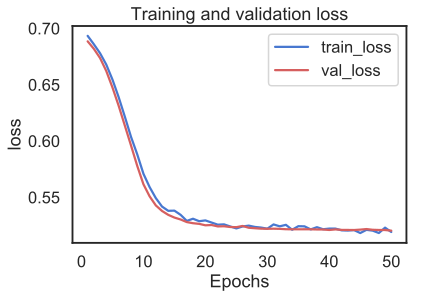

In [8]:
# Visualization of loss
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plot_metric(history, 'loss')

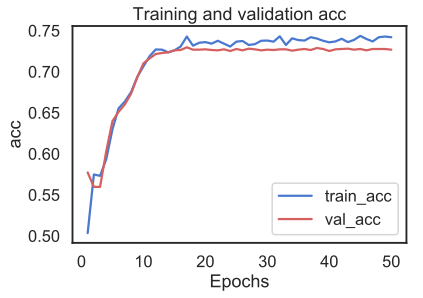

In [9]:
# Visualization of accuracy
plot_metric(history, 'acc')

## Predictions and their distribution

In [10]:
# PREDICTIONS
y_pred_1 = pd.Series(clf_1.predict(X_test).ravel(), index=y_test.index)
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred_1>0.5)):.1f}%")

Accuracy: 72.7%


C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

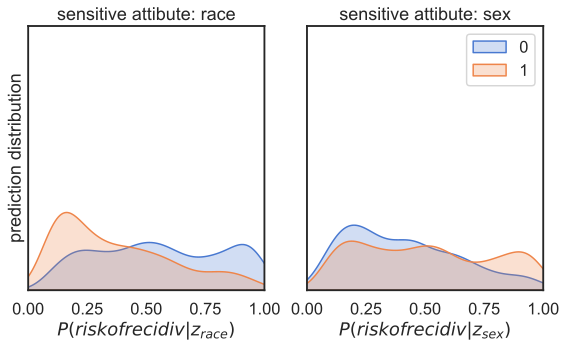

In [11]:
fig = plot_distributions(y_pred_1, Z_test)
# RACE: 0 = black , 1 = caucasian
# GENDER: 0 = women, 1 = men

From the plot above, the bias is clear. In particular: 

* The probability of being predicted at high risk of recidivisim is higher for people of color (blue area always higher than the orange one for values over 0.5)
* For caucasian people, the probability of being a recedivist is skewed to the left
* For a male individual, it is more likely to be predicted as recedivist, compared to a woman

In [12]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred_1, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred_1, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 51%-rule
	given attribute sex;  67%-rule


The p-rule confirms what observed in the plots above.

## Performance metrics

In [13]:
################################################################
###############################################################
# Computation of the True Positive, True Negative, False Positive, False Negative metrics WITH RESPECT TO THE ACTUAL OBSERVED RECIDIVISM 
# (not with respect to the target of the network, that is COMPAS prediction risk)

# Creation of the dataframe ('results') for computations
y_hats_1  = pd.DataFrame(y_pred_1) # predictions of the recidivism risk of the network I built
y_test_TRUE = pd.DataFrame(y_factual_test) # actual criminal activity (observed in the 2 years following the COMPAS score)
y_test_COMPAS = pd.DataFrame(y_test) # target values (COMPAS prediction of recidivism risk (target column of the original dataset))
y_hats_1_new = y_hats_1.rename(columns={0:'y_hats_1'})
# A person is considered at high risk, if the probability is > 0.5
y_hats_1_new.loc[y_hats_1_new['y_hats_1'] >= 0.5, 'pred_1'] = 1
y_hats_1_new.loc[y_hats_1_new['y_hats_1'] < 0.5, 'pred_1'] = 0

results = pd.concat([y_hats_1_new,y_test_TRUE], axis = 1)
results['race'] = Z_test.loc[:,'race']
results['y_test'] = y_test_COMPAS.loc[:,'target']
results['sex'] = Z_test.loc[:,'sex']

In [18]:
# TRUE POSITIVES and TRUE NEGATIVES regardless of race of my Feed Forward NN
true_positive_1 = results[(results['pred_1']==1) & (results['two_year_recid']==1)].count()
true_negative_1 = results[(results['pred_1']==0) & (results['two_year_recid']==0)].count()
false_positive_1 = results[(results['pred_1']==1) & (results['two_year_recid']==0)].count()
false_negative_1 = results[(results['pred_1']==0) & (results['two_year_recid']==1)].count()

In [16]:
count_by_race = results['race'].value_counts()
count_by_race
# 0 = black, 1 = caucasian

0    1489
1     971
Name: race, dtype: int64

In [19]:
print('TRUE POSITIVE: ', true_positive_1[0])
print('TRUE NEGATIVE: ', true_negative_1[0])
print('FALSE POSITIVE: ', false_positive_1[0])
print('FALSE NEGATIVE: ', false_negative_1[0])

TRUE POSITIVE:  719
TRUE NEGATIVE:  919
FALSE POSITIVE:  386
FALSE NEGATIVE:  436


In [21]:
# TRUE POSITIVES and TRUE NEGATIVES by race of my Feed Forward nn
true_positive_1_cauc_my = results[(results['pred_1']==1) & (results['two_year_recid']==1) & (results['race']==1)].count()
true_positive_1_afam_my = results[(results['pred_1']==1) & (results['two_year_recid']==1) & (results['race']==0)].count()
true_negative_1_cauc_my = results[(results['pred_1']==0) & (results['two_year_recid']==0)& (results['race']==1)].count()
true_negative_1_afam_my = results[(results['pred_1']==0) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_positive_1_cauc_my = results[(results['pred_1']==1) & (results['two_year_recid']==0)& (results['race']==1)].count()
false_positive_1_afam_my = results[(results['pred_1']==1) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_negative_1_cauc_my = results[(results['pred_1']==0) & (results['two_year_recid']==1)& (results['race']==1)].count()
false_negative_1_afam_my = results[(results['pred_1']==0) & (results['two_year_recid']==1)& (results['race']==0)].count()

In [22]:
# Overall accuracy regardless of race and by race of my Feed Forward nn
print('ACCURACY WRT REAL DATA', (true_positive_1[0]+true_negative_1[0])/results.shape[0])
print('ACCURACY wrt real, Cauc: ', (true_positive_1_cauc_my[0]+true_negative_1_cauc_my[0])/count_by_race[1])
print('ACCURACY wrt real, Afam: ', (true_positive_1_afam_my[0]+true_negative_1_afam_my[0])/count_by_race[0])

ACCURACY WRT REAL DATA 0.6658536585365854
ACCURACY wrt real, Cauc:  0.6601441812564367
ACCURACY wrt real, Afam:  0.6695768972464742


Overall accuracy seems almost the same for the two groups; but is it enough to conclude that the algorith is fair?

In [23]:
# Counts of people that are or are not real recidivists (that is, people that should have been classified respectively as 1 and 0 by the nn)
true_recidivists_cauc = results[(results['two_year_recid']==1) & (results['race']==1)].count()
true_recidivists_afam = results[(results['two_year_recid']==1) & (results['race']==0)].count()
true_non_recidivists_cauc = results[(results['two_year_recid']==0) & (results['race']==1)].count()
true_non_recidivists_afam = results[(results['two_year_recid']==0) & (results['race']==0)].count()

In [24]:
# TP, TN, FP, FN Rates by race and regardless of race of my nn
print('TRUE POSITIVE RATE Cauc: ', true_positive_1_cauc_my[0]/true_recidivists_cauc[0])
print('TRUE POSITIVE RATE Af-Am: ', true_positive_1_afam_my[0]/true_recidivists_afam[0])
print('TRUE POSITIVE RATE OVERALL: ', true_positive_1[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))
print('------------------------------------')
print('TRUE NEGATIVE RATE Cauc: ', true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])
print('TRUE NEGATIVE RATE Af-Am: ', true_negative_1_afam_my[0]/true_non_recidivists_afam[0])
print('TRUE NEGATIVE RATE OVERALL: ', true_negative_1[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))
print('------------------------------------')
print('FALSE NEGATIVE RATE Cauc: ', (1-(true_positive_1_cauc_my[0]/true_recidivists_cauc[0])))
print('FALSE NEGATIVE RATE Af-Am: ', (1-(true_positive_1_afam_my[0]/true_recidivists_afam[0])))
print('FALSE NEGATIVE RATE OVERALL: ',(1- (true_positive_1[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))))
print('------------------------------------')
print('FALSE POSITIVE RATE Cauc: ', (1-(true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])))
print('FALSE POSITIVE RATE Af-Am: ', (1-(true_negative_1_afam_my[0]/true_non_recidivists_afam[0])))
print('TRUE POSITIVE RATE OVERALL: ', (1-(true_negative_1[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))))

TRUE POSITIVE RATE Cauc:  0.4274193548387097
TRUE POSITIVE RATE Af-Am:  0.7151979565772669
TRUE POSITIVE RATE OVERALL:  0.6225108225108225
------------------------------------
TRUE NEGATIVE RATE Cauc:  0.8046744574290484
TRUE NEGATIVE RATE Af-Am:  0.6189801699716714
TRUE NEGATIVE RATE OVERALL:  0.7042145593869732
------------------------------------
FALSE NEGATIVE RATE Cauc:  0.5725806451612903
FALSE NEGATIVE RATE Af-Am:  0.2848020434227331
FALSE NEGATIVE RATE OVERALL:  0.37748917748917754
------------------------------------
FALSE POSITIVE RATE Cauc:  0.19532554257095158
FALSE POSITIVE RATE Af-Am:  0.3810198300283286
TRUE POSITIVE RATE OVERALL:  0.2957854406130268


While accuracy seems to be the same, it is clear that my Feed Forward NN performs in favour of the Caucasian group, as it has a higher __FALSE NEGATIVE RATE__, while the __FALSE POSITIVE RATE__ is higher for people of color, resulting in potentially wrong actions due to a high risk prediction for people having actual low risk of recidivisim. 

This shows that looking at _how bad_ the algorith is, is as (if not more) important as assessing how good it is in making predictions

In [25]:
compaspred_recid_afam = results[ (results['pred_1']==1) & (results['race']==0)].count() # people 
compaspred_recid_cauc = results[ (results['pred_1']==1) & (results['race']==1)].count()
total_true_recid = results[(results['two_year_recid']==1)].count()
print('TRUE RECIDIVISTS Cauc:', true_recidivists_cauc[0])
print('TRUE RECIDIVISTS AfAm: ', true_recidivists_afam[0])
print('COMPAS PREDICTED RECIDIVISTS Cauc:', compaspred_recid_cauc[0])
print('COMPAS PREDICTED RECIDIVISTS AfAm: ', compaspred_recid_afam[0])
print('TOTAL NUMBER OF RECIDIVISTS (Test set): ', total_true_recid[0])

TRUE RECIDIVISTS Cauc: 372
TRUE RECIDIVISTS AfAm:  783
COMPAS PREDICTED RECIDIVISTS Cauc: 276
COMPAS PREDICTED RECIDIVISTS AfAm:  829
TOTAL NUMBER OF RECIDIVISTS (Test set):  1155


Let's verify whether my Feed Forward NN can be considered similar to the COMPAS algorithm in terms of results. To check this, I can compute the same metrics using the __y_test__ column, which contains the prediction made by the _real_ (actually used) COMPAS algorithm:

In [26]:
# TP, TN, FP, FN by race of the COMPAS predictions in the test set: here I am comparing the COMPAS predictions (!= predictions of my nn) 
# with the actual recidivism
true_positive_1_cauc = results[(results['y_test']==1) & (results['two_year_recid']==1) & (results['race']==1)].count()
true_positive_1_afam = results[(results['y_test']==1) & (results['two_year_recid']==1) & (results['race']==0)].count()
true_negative_1_cauc = results[(results['y_test']==0) & (results['two_year_recid']==0)& (results['race']==1)].count()
true_negative_1_afam = results[(results['y_test']==0) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_positive_1_cauc = results[(results['y_test']==1) & (results['two_year_recid']==0)& (results['race']==1)].count()
false_positive_1_afam = results[(results['y_test']==1) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_negative_1_cauc = results[(results['y_test']==0) & (results['two_year_recid']==1)& (results['race']==1)].count()
false_negative_1_afam = results[(results['y_test']==0) & (results['two_year_recid']==1)& (results['race']==0)].count()

In [27]:
##########################################################################################################
# FINAL SUMMARY OF ALL THE METRICS
# 'original dataset' stands for rates of the COMPAS predictions (column 'target' of the original dataframe)
# ' FFNN pred' stands for rates of the predictions obtained with the Feed Forward nn I built to mimic COMPAS
print('TRUE POSITIVE RATE Cauc (original dataset): ', true_positive_1_cauc[0]/true_recidivists_cauc[0])
print('TRUE POSITIVE RATE Cauc (FFNN pred): ', true_positive_1_cauc_my[0]/true_recidivists_cauc[0])
print('TRUE POSITIVE RATE Af-Am (original dataset): ', true_positive_1_afam[0]/true_recidivists_afam[0])
print('TRUE POSITIVE RATE Af-Am (FFNN pred): ', true_positive_1_afam_my[0]/true_recidivists_afam[0])
print('--------------------------------------------------------------')
print('TRUE NEGATIVE RATE Cauc (original dataset): ', true_negative_1_cauc[0]/true_non_recidivists_cauc[0])
print('TRUE NEGATIVE RATE Cauc (FFNN pred): ', true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])
print('TRUE NEGATIVE RATE Af-Am (original dataset): ', true_negative_1_afam[0]/true_non_recidivists_afam[0])
print('TRUE NEGATIVE RATE Af-Am (FFNN pred): ', true_negative_1_afam_my[0]/true_non_recidivists_afam[0])
print('--------------------------------------------------------------')
print('FALSE NEGATIVE RATE Cauc (original dataset): ', (1-(true_positive_1_cauc[0]/true_recidivists_cauc[0])))
print('FALSE NEGATIVE RATE Cauc (FFNN pred): ', (1-(true_positive_1_cauc_my[0]/true_recidivists_cauc[0])))
print('FALSE NEGATIVE RATE Af-Am (original dataset): ', (1-(true_positive_1_afam[0]/true_recidivists_afam[0])))
print('FALSE NEGATIVE RATE Af-Am (FFNN pred): ', (1-(true_positive_1_afam_my[0]/true_recidivists_afam[0])))
print('--------------------------------------------------------------')
print('FALSE POSITIVE RATE Cauc (original dataset): ', (1-(true_negative_1_cauc[0]/true_non_recidivists_cauc[0])))
print('FALSE POSITIVE RATE Cauc (FFNN pred): ', (1-(true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])))
print('FALSE POSITIVE RATE Af-Am (original dataset): ', (1-(true_negative_1_afam[0]/true_non_recidivists_afam[0])))
print('FALSE POSITIVE RATE Af-Am (FFNN pred): ', (1-(true_negative_1_afam_my[0]/true_non_recidivists_afam[0])))

TRUE POSITIVE RATE Cauc (original dataset):  0.49731182795698925
TRUE POSITIVE RATE Cauc (FFNN pred):  0.4274193548387097
TRUE POSITIVE RATE Af-Am (original dataset):  0.7292464878671775
TRUE POSITIVE RATE Af-Am (FFNN pred):  0.7151979565772669
--------------------------------------------------------------
TRUE NEGATIVE RATE Cauc (original dataset):  0.7595993322203672
TRUE NEGATIVE RATE Cauc (FFNN pred):  0.8046744574290484
TRUE NEGATIVE RATE Af-Am (original dataset):  0.5594900849858357
TRUE NEGATIVE RATE Af-Am (FFNN pred):  0.6189801699716714
--------------------------------------------------------------
FALSE NEGATIVE RATE Cauc (original dataset):  0.5026881720430108
FALSE NEGATIVE RATE Cauc (FFNN pred):  0.5725806451612903
FALSE NEGATIVE RATE Af-Am (original dataset):  0.2707535121328225
FALSE NEGATIVE RATE Af-Am (FFNN pred):  0.2848020434227331
--------------------------------------------------------------
FALSE POSITIVE RATE Cauc (original dataset):  0.24040066777963276
FALSE PO

We can conclude that my Feed Forward NN performs very similarly to the COMPAS algorithm!

# Generative Adversarial Network (GAN)

Let's build a GAN architecture trying to eliminate the bias present in the data

In [28]:
clf_2 = FairClassifier(n_features = X_train.shape[1], n_sensitive = Z_train.shape[1], lambdas = [130., 30.])

# pre-train both adverserial and classifier networks
clf_2.pretrain(X_train, y_train, Z_train, verbose=2, epochs=10)

Epoch 1/10
 - 0s - loss: 0.6503
Epoch 2/10
 - 0s - loss: 0.5573
Epoch 3/10
 - 0s - loss: 0.5364
Epoch 4/10
 - 0s - loss: 0.5299
Epoch 5/10
 - 0s - loss: 0.5262
Epoch 6/10
 - 0s - loss: 0.5264
Epoch 7/10
 - 0s - loss: 0.5238
Epoch 8/10
 - 0s - loss: 0.5225
Epoch 9/10
 - 0s - loss: 0.5213
Epoch 10/10
 - 0s - loss: 0.5231
Epoch 1/10
 - 0s - loss: 1.3679 - model_3_loss: 0.6891
Epoch 2/10
 - 0s - loss: 1.3449 - model_3_loss: 0.6831
Epoch 3/10
 - 0s - loss: 1.3363 - model_3_loss: 0.6793
Epoch 4/10
 - 0s - loss: 1.3349 - model_3_loss: 0.6786
Epoch 5/10
 - 0s - loss: 1.3348 - model_3_loss: 0.6795
Epoch 6/10
 - 0s - loss: 1.3341 - model_3_loss: 0.6792
Epoch 7/10
 - 0s - loss: 1.3333 - model_3_loss: 0.6783
Epoch 8/10
 - 0s - loss: 1.3324 - model_3_loss: 0.6787
Epoch 9/10
 - 0s - loss: 1.3316 - model_3_loss: 0.6777
Epoch 10/10
 - 0s - loss: 1.3331 - model_3_loss: 0.6785


C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\miria\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

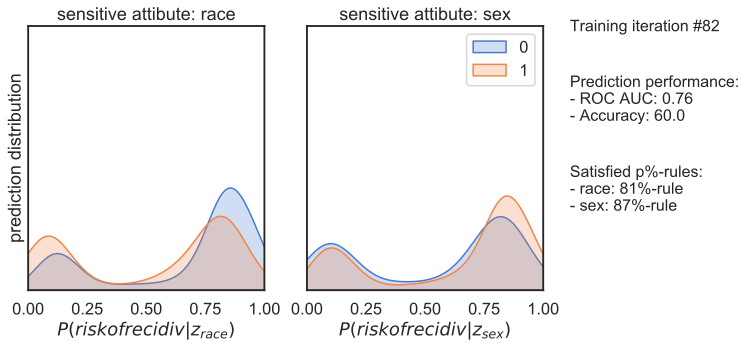

In [29]:
# GAN actual Training
history_2 = clf_2.fit(X_train, y_train, Z_train, validation_data = (X_test, y_test, Z_test), T_iter = 82, save_figs = False)

## Predictions 

In [30]:
############################################################################
# PREDICTIONS
y_pred_2 = pd.Series(clf_2.predict(X_test).ravel(), index=y_test.index)
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred_2>0.5)):.1f}%")

Accuracy: 59.9%


While accuracy dropped, we now have what seems to be a fair result

## Performance Metrics

In [31]:
# Preparing columns to add to the previous dataframe ('results') used to compute metrics
y_hats_2  = pd.DataFrame(y_pred_2)
y_hats_2_new = y_hats_2.rename(columns={0:'y_hats_2'})
y_hats_2_new.loc[y_hats_2_new['y_hats_2'] >= 0.5, 'pred_2'] = 1
y_hats_2_new.loc[y_hats_2_new['y_hats_2'] < 0.5, 'pred_2'] = 0

results[['y_hats_2','pred_2']] = y_hats_2_new.loc[:,['y_hats_2','pred_2']] # adding probabilities and classification of GAN
results[['y_hats_2','pred_2']] = y_hats_2_new.loc[:,['y_hats_2','pred_2']]
results.head()

,y_hats_1,pred_1,two_year_recid,race,y_test,sex,y_hats_2,pred_2
3144,0.195046,0.0,0,0,1,1,0.692594,1.0
493,0.299777,0.0,0,0,0,1,0.112970,0.0
4206,0.597084,1.0,1,0,1,0,0.841715,1.0
1523,0.085970,0.0,0,1,1,1,0.040702,0.0
1135,0.317722,0.0,1,1,1,1,0.800353,1.0


In [32]:
# TRUE POSITIVES and TRUE NEGATIVES regardless of race of GAN
true_positive_2 = results[(results['pred_2']==1) & (results['two_year_recid']==1)].count()
true_negative_2 = results[(results['pred_2']==0) & (results['two_year_recid']==0)].count()
false_positive_2 = results[(results['pred_2']==1) & (results['two_year_recid']==0)].count()
false_negative_2 = results[(results['pred_2']==0) & (results['two_year_recid']==1)].count()

In [33]:
print('TRUE POSITIVE GAN: ', true_positive_2[0])
print('TRUE NEGATIVE GAN: ', true_negative_2[0])
print('FALSE POSITIVE GAN: ', false_positive_2[0])
print('FALSE NEGATIVE GAN: ', false_negative_2[0])
print('ACCURACY WRT REAL DATA', (true_positive_2[0]+true_negative_2[0])/results.shape[0])

TRUE POSITIVE GAN:  888
TRUE NEGATIVE GAN:  488
FALSE POSITIVE GAN:  817
FALSE NEGATIVE GAN:  267
ACCURACY WRT REAL DATA 0.5593495934959349


In [34]:
# TP, TN, FP, FN by race of GAN
true_positive_2_cauc_my = results[(results['pred_2']==1) & (results['two_year_recid']==1) & (results['race']==1)].count()
true_positive_2_afam_my = results[(results['pred_2']==1) & (results['two_year_recid']==1) & (results['race']==0)].count()
true_negative_2_cauc_my = results[(results['pred_2']==0) & (results['two_year_recid']==0)& (results['race']==1)].count()
true_negative_2_afam_my = results[(results['pred_2']==0) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_positive_2_cauc_my = results[(results['pred_2']==1) & (results['two_year_recid']==0)& (results['race']==1)].count()
false_positive_2_afam_my = results[(results['pred_2']==1) & (results['two_year_recid']==0)& (results['race']==0)].count()
false_negative_2_cauc_my = results[(results['pred_2']==0) & (results['two_year_recid']==1)& (results['race']==1)].count()
false_negative_2_afam_my = results[(results['pred_2']==0) & (results['two_year_recid']==1)& (results['race']==0)].count()

In [35]:
print('TP by race (GAN) ','CAUC',true_positive_2_cauc_my[0],'AFAM',true_positive_2_afam_my[0])
print('-------------------------------')
print('TN by race (GAN) ','CAUC',true_negative_2_cauc_my[0],'AFAM',true_negative_2_afam_my[0])
print('-------------------------------')
print('FP by race (GAN) ','CAUC',false_positive_2_cauc_my[0],'AFAM',false_positive_2_afam_my[0])
print('-------------------------------')
print('FN by race (GAN) ','CAUC',false_negative_2_cauc_my[0],'AFAM',false_negative_2_afam_my[0])
print('-------------------------------')
print('ACCURACY wrt real, Cauc: ', (true_positive_2_cauc_my[0]+true_negative_2_cauc_my[0])/count_by_race[1])
print('ACCURACY wrt real, Afam: ', (true_positive_2_afam_my[0]+true_negative_2_afam_my[0])/count_by_race[0])
print('ACCURACY wrt real, ALL: ', (true_positive_2[0]+true_negative_2[0])/(count_by_race[0]+count_by_race[1]))

TP by race (GAN)  CAUC 257 AFAM 631
-------------------------------
TN by race (GAN)  CAUC 266 AFAM 222
-------------------------------
FP by race (GAN)  CAUC 333 AFAM 484
-------------------------------
FN by race (GAN)  CAUC 115 AFAM 152
-------------------------------
ACCURACY wrt real, Cauc:  0.5386199794026777
ACCURACY wrt real, Afam:  0.5728676964405641
ACCURACY wrt real, ALL:  0.5593495934959349


In [36]:
compaspred_recid_afam_GAN = results[ (results['pred_2']==1) & (results['race']==0)].count()
compaspred_recid_cauc_GAN = results[ (results['pred_2']==1) & (results['race']==1)].count()
total_true_recid = results[(results['two_year_recid']==1)].count()
print('COMPAS PREDICTED RECIDIVISTS GAN Cauc:', compaspred_recid_cauc_GAN[0])
print('COMPAS PREDICTED RECIDIVISTS GAN AfAm: ', compaspred_recid_afam_GAN[0])
print('TOTAL NUMBER OF RECIDIVISTS (Test set): ', total_true_recid[0])

COMPAS PREDICTED RECIDIVISTS GAN Cauc: 590
COMPAS PREDICTED RECIDIVISTS GAN AfAm:  1115
TOTAL NUMBER OF RECIDIVISTS (Test set):  1155


# Comparing the two models

In [37]:
###################################################################################
# Final summary of all the metrics
# By race
true_pos_rate_or_cauc = true_positive_1_cauc[0]/true_recidivists_cauc[0]
true_pos_rate_FFNN_cauc = true_positive_1_cauc_my[0]/true_recidivists_cauc[0]
true_pos_rate_GAN_cauc = true_positive_2_cauc_my[0]/true_recidivists_cauc[0]

true_pos_rate_or_afam = true_positive_1_afam[0]/true_recidivists_afam[0]
true_pos_rate_FFNN_afam = true_positive_1_afam_my[0]/true_recidivists_afam[0]
true_pos_rate_GAN_afam = true_positive_2_afam_my[0]/true_recidivists_afam[0]

true_neg_rate_or_cauc = true_negative_1_cauc[0]/true_non_recidivists_cauc[0]
true_neg_rate_FFNN_cauc = true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0]
true_neg_rate_GAN_cauc = true_negative_2_cauc_my[0]/true_non_recidivists_cauc[0]

true_neg_rate_or_afam = true_negative_1_afam[0]/true_non_recidivists_afam[0]
true_neg_rate_FFNN_afam = true_negative_1_afam_my[0]/true_non_recidivists_afam[0]
true_neg_rate_GAN_afam = true_negative_2_afam_my[0]/true_non_recidivists_afam[0]

false_neg_rate_or_cauc = (1-(true_positive_1_cauc[0]/true_recidivists_cauc[0]))
false_neg_rate_FFNN_cauc = (1-(true_positive_1_cauc_my[0]/true_recidivists_cauc[0]))
false_neg_rate_GAN_cauc = (1-(true_positive_2_cauc_my[0]/true_recidivists_cauc[0]))

false_neg_rate_or_afam = (1-(true_positive_1_afam[0]/true_recidivists_afam[0]))
false_neg_rate_FFNN_afam = (1-(true_positive_1_afam_my[0]/true_recidivists_afam[0]))
false_neg_rate_GAN_afam = (1-(true_positive_2_afam_my[0]/true_recidivists_afam[0]))

false_pos_rate_or_cauc = (1-(true_negative_1_cauc[0]/true_non_recidivists_cauc[0]))
false_pos_rate_FFNN_cauc = (1-(true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0]))
false_pos_rate_GAN_cauc = (1-(true_negative_2_cauc_my[0]/true_non_recidivists_cauc[0]))

false_pos_rate_or_afam = (1-(true_negative_1_afam[0]/true_non_recidivists_afam[0]))
false_pos_rate_FFNN_afam = (1-(true_negative_1_afam_my[0]/true_non_recidivists_afam[0]))
false_pos_rate_GAN_afam = (1-(true_negative_2_afam_my[0]/true_non_recidivists_afam[0]))

In [39]:
print('TRUE POSITIVE RATE Cauc (original dataset): ', true_positive_1_cauc[0]/true_recidivists_cauc[0])
print('TRUE POSITIVE RATE Cauc (FFNN pred): ', true_positive_1_cauc_my[0]/true_recidivists_cauc[0])
print('TRUE POSITIVE RATE Cauc (GAN pred): ', true_positive_2_cauc_my[0]/true_recidivists_cauc[0])
print('--------------------------------------------------------------')
print('TRUE POSITIVE RATE Af-Am (original dataset): ', true_positive_1_afam[0]/true_recidivists_afam[0])
print('TRUE POSITIVE RATE Af-Am (FFNN pred): ', true_positive_1_afam_my[0]/true_recidivists_afam[0])
print('TRUE POSITIVE RATE Af-Am (GAN pred): ', true_positive_2_afam_my[0]/true_recidivists_afam[0])
print('--------------------------------------------------------------')
print('TRUE NEGATIVE RATE Cauc (original dataset): ', true_negative_1_cauc[0]/true_non_recidivists_cauc[0])
print('TRUE NEGATIVE RATE Cauc (FFNN pred): ', true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])
print('TRUE NEGATIVE RATE Cauc (GAN pred): ', true_negative_2_cauc_my[0]/true_non_recidivists_cauc[0])
print('--------------------------------------------------------------')
print('TRUE NEGATIVE RATE Af-Am (original dataset): ', true_negative_1_afam[0]/true_non_recidivists_afam[0])
print('TRUE NEGATIVE RATE Af-Am (FFNN pred): ', true_negative_1_afam_my[0]/true_non_recidivists_afam[0])
print('TRUE NEGATIVE RATE Af-Am (GAN pred): ', true_negative_2_afam_my[0]/true_non_recidivists_afam[0])
print('--------------------------------------------------------------')

TRUE POSITIVE RATE Cauc (original dataset):  0.49731182795698925
TRUE POSITIVE RATE Cauc (FFNN pred):  0.4274193548387097
TRUE POSITIVE RATE Cauc (GAN pred):  0.6908602150537635
--------------------------------------------------------------
TRUE POSITIVE RATE Af-Am (original dataset):  0.7292464878671775
TRUE POSITIVE RATE Af-Am (FFNN pred):  0.7151979565772669
TRUE POSITIVE RATE Af-Am (GAN pred):  0.8058748403575989
--------------------------------------------------------------
TRUE NEGATIVE RATE Cauc (original dataset):  0.7595993322203672
TRUE NEGATIVE RATE Cauc (FFNN pred):  0.8046744574290484
TRUE NEGATIVE RATE Cauc (GAN pred):  0.44407345575959933
--------------------------------------------------------------
TRUE NEGATIVE RATE Af-Am (original dataset):  0.5594900849858357
TRUE NEGATIVE RATE Af-Am (FFNN pred):  0.6189801699716714
TRUE NEGATIVE RATE Af-Am (GAN pred):  0.31444759206798867
--------------------------------------------------------------


In [40]:
print('--------------------------------------------------------------')
print('FALSE NEGATIVE RATE Cauc (original dataset): ', (1-(true_positive_1_cauc[0]/true_recidivists_cauc[0])))
print('FALSE NEGATIVE RATE Cauc (FFNN pred): ', (1-(true_positive_1_cauc_my[0]/true_recidivists_cauc[0])))
print('FALSE NEGATIVE RATE Cauc (GAN pred): ', (1-(true_positive_2_cauc_my[0]/true_recidivists_cauc[0])))
print('--------------------------------------------------------------')
print('FALSE NEGATIVE RATE Af-Am (original dataset): ', (1-(true_positive_1_afam[0]/true_recidivists_afam[0])))
print('FALSE NEGATIVE RATE Af-Am (FFNN pred): ', (1-(true_positive_1_afam_my[0]/true_recidivists_afam[0])))
print('FALSE NEGATIVE RATE Af-Am (GAN pred): ', (1-(true_positive_2_afam_my[0]/true_recidivists_afam[0])))
print('--------------------------------------------------------------')
print('FALSE POSITIVE RATE Cauc (original dataset): ', (1-(true_negative_1_cauc[0]/true_non_recidivists_cauc[0])))
print('FALSE POSITIVE RATE Cauc (FFNN pred): ', (1-(true_negative_1_cauc_my[0]/true_non_recidivists_cauc[0])))
print('FALSE POSITIVE RATE Cauc (GAN pred): ', (1-(true_negative_2_cauc_my[0]/true_non_recidivists_cauc[0])))
print('--------------------------------------------------------------')
print('FALSE POSITIVE RATE Af-Am (original dataset): ', (1-(true_negative_1_afam[0]/true_non_recidivists_afam[0])))
print('FALSE POSITIVE RATE Af-Am (FFNN pred): ', (1-(true_negative_1_afam_my[0]/true_non_recidivists_afam[0])))
print('FALSE POSITIVE RATE Af-Am (GAN pred): ', (1-(true_negative_2_afam_my[0]/true_non_recidivists_afam[0])))

--------------------------------------------------------------
FALSE NEGATIVE RATE Cauc (original dataset):  0.5026881720430108
FALSE NEGATIVE RATE Cauc (FFNN pred):  0.5725806451612903
FALSE NEGATIVE RATE Cauc (GAN pred):  0.3091397849462365
--------------------------------------------------------------
FALSE NEGATIVE RATE Af-Am (original dataset):  0.2707535121328225
FALSE NEGATIVE RATE Af-Am (FFNN pred):  0.2848020434227331
FALSE NEGATIVE RATE Af-Am (GAN pred):  0.19412515964240107
--------------------------------------------------------------
FALSE POSITIVE RATE Cauc (original dataset):  0.24040066777963276
FALSE POSITIVE RATE Cauc (FFNN pred):  0.19532554257095158
FALSE POSITIVE RATE Cauc (GAN pred):  0.5559265442404007
--------------------------------------------------------------
FALSE POSITIVE RATE Af-Am (original dataset):  0.44050991501416425
FALSE POSITIVE RATE Af-Am (FFNN pred):  0.3810198300283286
FALSE POSITIVE RATE Af-Am (GAN pred):  0.6855524079320113


In [41]:
# regardless of race
print('TRUE POSITIVE RATE OVERALL FFNN: ', true_positive_1[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))
print('TRUE POSITIVE RATE OVERALL GAN: ', true_positive_2[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))
print('------------------------------------')
print('TRUE NEGATIVE RATE OVERALL FFNN : ', true_negative_1[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))
print('TRUE NEGATIVE RATE OVERALL GAN : ', true_negative_2[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))
print('------------------------------------')
print('FALSE NEGATIVE RATE OVERALL FFNN: ',(1- (true_positive_1[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))))
print('FALSE NEGATIVE RATE OVERALL GAN: ',(1- (true_positive_2[0]/(true_recidivists_afam[0]+true_recidivists_cauc[0]))))
print('------------------------------------')
print('TRUE POSITIVE RATE OVERALL FFNN: ', (1-(true_negative_1[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))))
print('TRUE POSITIVE RATE OVERALL GAN: ', (1-(true_negative_2[0]/(true_non_recidivists_afam[0]+true_non_recidivists_cauc[0]))))

TRUE POSITIVE RATE OVERALL FFNN:  0.6225108225108225
TRUE POSITIVE RATE OVERALL GAN:  0.7688311688311689
------------------------------------
TRUE NEGATIVE RATE OVERALL FFNN :  0.7042145593869732
TRUE NEGATIVE RATE OVERALL GAN :  0.3739463601532567
------------------------------------
FALSE NEGATIVE RATE OVERALL FFNN:  0.37748917748917754
FALSE NEGATIVE RATE OVERALL GAN:  0.23116883116883113
------------------------------------
TRUE POSITIVE RATE OVERALL FFNN:  0.2957854406130268
TRUE POSITIVE RATE OVERALL GAN:  0.6260536398467433


In [42]:
#  Differences in absolute value in the rates 
print('Difference in rates between races (in absolute value):')
print('--------------------------------------------------------------')
print('DIFF TRUE POSITIVE (original dataset): ', abs(true_pos_rate_or_cauc-true_pos_rate_or_afam))
print('DIFF TRUE POSITIVE (FFNN pred): ', abs(true_pos_rate_FFNN_cauc-true_pos_rate_FFNN_afam))
print('DIFF TRUE POSITIVE (GAN pred): ', abs(true_pos_rate_GAN_afam-true_pos_rate_GAN_cauc))
print('--------------------------------------------------------------')
print('DIFF TRUE NEGATIVE (original dataset): ', abs(true_neg_rate_or_cauc-true_neg_rate_or_afam))
print('DIFF TRUE NEGATIVE (FFNN pred): ', abs(true_neg_rate_FFNN_cauc-true_neg_rate_FFNN_afam))
print('DIFF TRUE NEGATIVE (GAN pred): ', abs(true_neg_rate_GAN_cauc-true_neg_rate_GAN_afam))
print('--------------------------------------------------------------')
print('DIFF FALSE POSITIVE (original dataset): ', abs(false_pos_rate_or_cauc-false_pos_rate_or_afam))
print('DIFF FALSE POSITIVE (FFNN pred): ', abs(false_pos_rate_FFNN_cauc-false_pos_rate_FFNN_afam))
print('DIFF FALSE POSITIVE (GAN pred): ', abs(false_pos_rate_GAN_afam-false_pos_rate_GAN_cauc))
print('--------------------------------------------------------------')
print('DIFF FALSE NEGATIVE (original dataset): ', abs(false_neg_rate_or_cauc-false_neg_rate_or_afam))
print('DIFF FALSE NEGATIVE (FFNN pred): ', abs(false_neg_rate_FFNN_cauc-false_neg_rate_FFNN_afam))
print('DIFF FALSE NEGATIVE (GAN pred): ', abs(false_neg_rate_GAN_cauc-false_neg_rate_GAN_afam))

Difference in rates between races (in absolute value):
--------------------------------------------------------------
DIFF TRUE POSITIVE (original dataset):  0.23193465991018825
DIFF TRUE POSITIVE (FFNN pred):  0.28777860173855724
DIFF TRUE POSITIVE (GAN pred):  0.11501462530383544
--------------------------------------------------------------
DIFF TRUE NEGATIVE (original dataset):  0.2001092472345315
DIFF TRUE NEGATIVE (FFNN pred):  0.18569428745737704
DIFF TRUE NEGATIVE (GAN pred):  0.12962586369161067
--------------------------------------------------------------
DIFF FALSE POSITIVE (original dataset):  0.2001092472345315
DIFF FALSE POSITIVE (FFNN pred):  0.18569428745737704
DIFF FALSE POSITIVE (GAN pred):  0.12962586369161067
--------------------------------------------------------------
DIFF FALSE NEGATIVE (original dataset):  0.23193465991018825
DIFF FALSE NEGATIVE (FFNN pred):  0.2877786017385572
DIFF FALSE NEGATIVE (GAN pred):  0.11501462530383544


The results show that with the GAN training we obtain a fair result in terms of algorithm performance, reducing the difference in performance for the two segments. This comes at the price of a lower accuracy of the model. 

There are some problems for which accuracy is the most relevant performance metric; this is not the case. When applying such algorithms to people's lives, especially when consequences as parole and sentencing, it is not sufficient to look at how good the model is. If the way the algorithm makes errors is not uniformly distributed across significant sensible variables, it is not an ethical choice to use it. 